In [1]:
import os
import socket

%pylab inline
%load_ext autoreload
%autoreload 2
print(socket.gethostname())

Populating the interactive namespace from numpy and matplotlib
ift-dgx


In [2]:
import joblib
import numpy as np
import random
from Evaluation import evaluation
from Preprocessing import preprocessing
import sys
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
inspect_key       = 'Self-Identified Ethnicity'
#inspect_key       = 'Self-Identified Gender'
#inspect_key       = 'Age'
inspect_list      = ['Caucasian','Hispanic']
# inspect_list      = ['Male','Female']
inspect_threshold = 20
percentages       = np.arange(0,1.1,0.1)
use_trial_types   = ['TEX','BLG','FXS','HSS','RAN','VD1','VD2']
number_train      = 100
seconds_per_user  = 80
random_state      = 42
num_folds         = 10
save_dir          = 'saved_embeddings/'
GPU               = 1
flag_train_on_gpu = True
max_round         = 4
flag_test_judo    = True

Y_columns = {'subId': 0,
 'session': 1,
 'round': 2,
 'trial': 3}

Y_columns_judo = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

ethnicity_mapping = {'African':'Black',
                     'African American':'Black',
                     'African-American':'Black',
                     'Asian':'Asian',
                     'Asian/White':'Mixed',
                     'Black':'Black',
                     'Black/Hispanic':'Mixed',
                     'Caucasian':'Caucasian',
                     'Caucasian/Hispanic':'Mixed',
                     'European':'Caucasian',
                     'Hiaspanic/Black/Arab':'Mixed',
                     'Hispanic':'Hispanic',
                     'Hispanic/Caucasian':'Mixed',
                     'Hispanic/Latino':'Hispanic',
                     'Hispanic/Native American':'Mixed',
                     'Hispanic/While':'Mixed',
                     'Hispanic/White':'Mixed',
                     'Latina':'Hispanic',
                     'Lau':'Mixed',
                     'Mexican':'Hispanic',
                     'Mexican American':'Mixed',
                     'Mexican/Hispanic':'Hispanic',
                     'Middle-Eastern':'Mixed',
                     'Mixed':'Mixed',
                     'Multiracial':'Mixed',
                     'Native American':'Mixed',
                     'West Indian':'Mixed',
                     'White':'Caucasian',
                     'White-Hispanic':'Mixed',
                     'White/Hispanic':'Mixed',
                     'White/Mexican':'Mixed',
                     'White/Mexican American':'Mixed',
                     'Whtie':'Caucasian'}

age_mapping = {'young_threshold':20,
               'old_threshold': 30}

In [4]:
demo_info_df = pd.read_excel('GazeBase_v2_0/GazeBaseDemoInfo.xlsx')

demo_list = ['Age',
             'Self-Identified Gender',
             'Self-Identified Ethnicity',
             'normalized Ethnicity',
             'age_class']

ethno_list = list(demo_info_df['Self-Identified Ethnicity'])
normalized_ethno_list = []
for i in range(len(ethno_list)):
    normalized_ethno_list.append(ethnicity_mapping[ethno_list[i]])
demo_info_df['normalized Ethnicity'] = list(normalized_ethno_list)

age_list = []
age = list(demo_info_df['Age'])
for i in range(len(age)):
    cur_class = 'between'
    if age[i] <= age_mapping['young_threshold']:
        cur_class = 'younger'
    if age[i] >= age_mapping['old_threshold']:
        cur_class = 'older'
    age_list.append(cur_class)
demo_info_df['age_class'] = list(age_list)

demo_dict = dict()
for i in range(len(demo_info_df)):
    cur_line = demo_info_df.iloc[i]
    cur_part = cur_line['Participant ID']
    for demo_type in demo_list:
        if demo_type not in demo_dict:
            demo_dict[demo_type] = dict()
        demo_dict[demo_type][cur_part] = cur_line[demo_type]

In [5]:
gaze_base_raw_data_dirs = ['GazeBase_v2_0/Round_9/',
            'GazeBase_v2_0/Round_8/',
            'GazeBase_v2_0/Round_7/',
            'GazeBase_v2_0/Round_6/',
            'GazeBase_v2_0/Round_5/',
            'GazeBase_v2_0/Round_4/',
            'GazeBase_v2_0/Round_3/',
            'GazeBase_v2_0/Round_2/',
            'GazeBase_v2_0/Round_1/']
csv_files = []
for cur_dir in gaze_base_raw_data_dirs:
    csv_files += preprocessing.get_csvs(cur_dir)
print('number of csv files. ' + str(len(csv_files)))

round_list    = []
subject_list  = []
session_list  = []
trial_list    = []
path_list     = []
use_for_train = []
for csv_file in csv_files:
    #print(csv_file)
    file_name = csv_file.split('/')[-1]
    #print(file_name)
    file_name_split = file_name.replace('.csv','').split('_')
    cur_round = file_name_split[1][0]
    cur_subject = int(file_name_split[1][1:])
    cur_session = file_name_split[2]
    cur_trial = file_name_split[3]
    if cur_trial not in use_trial_types:
        continue
    if int(cur_round) > max_round:
        continue
    if inspect_key != 'Age':
        if demo_dict[inspect_key][cur_subject] not in inspect_list:
            use_for_train.append(0)
        else:
            use_for_train.append(1)
    else:
        use_for_train.append(1)
    round_list.append(cur_round)
    subject_list.append(cur_subject)
    session_list.append(cur_session)
    trial_list.append(cur_trial)
    path_list.append(csv_file)

data_csv = pd.DataFrame({'round':round_list,
                    'subject':subject_list,
                    'session':session_list,
                    'trial':trial_list,
                    'path':path_list})
data_csv.head()

number of csv files. 12334


,round,subject,session,trial,path
0,4,226,S2,BLG,GazeBase_v2_0/Round_4//Subject_4226//S2//S2_Ba...
1,4,226,S2,VD2,GazeBase_v2_0/Round_4//Subject_4226//S2//S2_Vi...
2,4,226,S2,VD1,GazeBase_v2_0/Round_4//Subject_4226//S2//S2_Vi...
3,4,226,S2,FXS,GazeBase_v2_0/Round_4//Subject_4226//S2//S2_Fi...
4,4,226,S2,TEX,GazeBase_v2_0/Round_4//Subject_4226//S2//S2_Re...


In [6]:
user_data_list = []
for i in tqdm(range(len(data_csv))):
    cur_line = data_csv.iloc[i]
    cur_path = cur_line['path']
    user_data_list.append(preprocessing.get_data_for_user(cur_path))

In [7]:
round_list = list(np.array(data_csv['round'],dtype=np.int32))
subject_list = list(np.array(data_csv['subject'],dtype=np.int32))
session_list = list(np.array(data_csv['session']))
trial_list = list(np.array(data_csv['trial']))

number_add = 20000

participants_per_session_dict = dict()
X = np.zeros([number_add,1000,2])
Y = np.zeros([number_add,4])
key_label = []
session_nr_dict = dict()
trial_nr_dict = dict()
counter = 0
key_sub_label = []
use_train_ids = []
for i in tqdm(range(len(user_data_list))):
    cur_id = i
    cur_subject = subject_list[cur_id]
    cur_session = session_list[cur_id]
    cur_key_label = demo_dict[inspect_key][cur_subject]
    if cur_session not in session_nr_dict:
        session_nr_dict[cur_session] = len(session_nr_dict)
    cur_round = round_list[cur_id]
    cur_trial = trial_list[cur_id]
    if cur_trial not in trial_nr_dict:
        trial_nr_dict[cur_trial] = len(trial_nr_dict)
    cur_data = user_data_list[cur_id]['X_vel_transformed']
    end_counter = counter + cur_data.shape[0]
    while X.shape[0] <= end_counter:
        X = np.vstack([X, np.zeros([number_add,cur_data.shape[1],cur_data.shape[2]])])
        Y = np.vstack([Y, np.zeros([number_add,4])])
    X[counter:end_counter] = cur_data
    Y[counter:end_counter,0] = cur_subject
    Y[counter:end_counter,1] = session_nr_dict[cur_session]
    Y[counter:end_counter,2] = cur_round
    Y[counter:end_counter,3] = trial_nr_dict[cur_trial]
    key_label += list([cur_key_label for a in range(cur_data.shape[0])])
    counter += cur_data.shape[0]
    if session_nr_dict[cur_session] not in participants_per_session_dict:
        participants_per_session_dict[session_nr_dict[cur_session]] = []
    participants_per_session_dict[session_nr_dict[cur_session]].append(cur_subject)
    key_sub_label.append(cur_key_label)
    use_train_label = use_for_train[cur_id]
    use_train_ids += list([use_train_label for a in range(cur_data.shape[0])])
X = X[0:counter]
Y = Y[0:counter]

for key in participants_per_session_dict.keys():
    participants_per_session_dict[key] = list(set(participants_per_session_dict[key]))
key_label = np.array(key_label)
key_sub_label = np.array(key_sub_label)
use_train_ids = np.array(use_train_ids)

In [8]:
print('X.shape: ' + str(X.shape))

X.shape: (553383, 1000, 2)


In [9]:
inverse_trial_nr_dict = dict()
for key in trial_nr_dict:
    inverse_trial_nr_dict[trial_nr_dict[key]] = key

In [10]:
normalized_ethnicities = []
task = []
for i in tqdm(np.arange(X.shape[0])):
    cur_id = Y[i,Y_columns['subId']]
    cur_et = demo_dict['normalized Ethnicity'][cur_id]
    normalized_ethnicities.append(cur_et)
    task.append(inverse_trial_nr_dict[Y[i,Y_columns['trial']]])
normalized_ethnicities = np.array(normalized_ethnicities)
task = np.array(task)

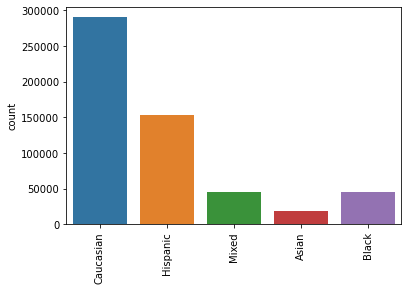

In [11]:
sns.countplot(x = normalized_ethnicities)
plt.xticks(rotation=90)
plt.show()

In [12]:
tex_task_ids = np.where(task == 'TEX')[0]
X_tex = X[tex_task_ids]
Y_tex = Y[tex_task_ids]
normalized_ethnicities_tex = normalized_ethnicities[tex_task_ids]

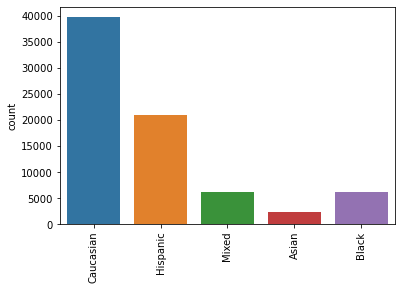

In [13]:
sns.countplot(x = normalized_ethnicities_tex)
plt.xticks(rotation=90)
plt.show()

## Plot for velocities for different ethnicities

In [14]:
num_per_et = 100000
np.random.seed(42)
et_list = ['Caucasian','Black','Hispanic','Asian']
data_array_x = []
data_array_y = []
for et in et_list:
    et_ids = np.where(normalized_ethnicities_tex == et)[0]
    cur_et_list_x = X_tex[et_ids,:,0].flatten()
    cur_et_list_y = X_tex[et_ids,:,1].flatten()
    rand_ids = np.random.permutation(np.arange(len(cur_et_list_x)))[0:num_per_et]
    cur_et_list_x = cur_et_list_x[rand_ids]
    cur_et_list_y = cur_et_list_y[rand_ids]
    data_array_x.append(cur_et_list_x)
    data_array_y.append(cur_et_list_y)

### x velocities

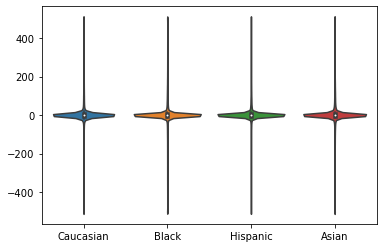

In [15]:
data_names = ['Caucasion','Black','Hispanic','Asian']

sns.violinplot(data = data_array_x)
plt.xticks(np.arange(len(data_array_x)), et_list)
plt.savefig('plots/violinplot_x_dva_ethicities.pdf')
plt.show()

### y velocities

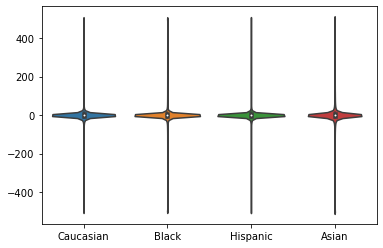

In [16]:
data_names = ['Caucasion','Black','Hispanic','Asian']

sns.violinplot(data = data_array_y)
plt.xticks(np.arange(len(data_array_y)), et_list)
plt.savefig('plots/violinplot_y_dva_ethicities.pdf')
plt.show()

###  Plot for velocities for different ethnicities [above 50 dva/s]

In [17]:
num_per_et = 100000
np.random.seed(42)
threshold = 50
et_list = ['Caucasian','Black','Hispanic','Asian']
data_array_x = []
data_array_y = []
for et in et_list:
    et_ids = np.where(normalized_ethnicities_tex == et)[0]
    cur_et_list_x = X_tex[et_ids,:,0].flatten()
    cur_et_list_x = cur_et_list_x[np.abs(cur_et_list_x) >= threshold]
    cur_et_list_y = X_tex[et_ids,:,1].flatten()
    cur_et_list_y = cur_et_list_y[np.abs(cur_et_list_y) >= threshold]
    rand_ids_x = np.random.permutation(np.arange(len(cur_et_list_x)))[0:num_per_et]
    rand_ids_y = np.random.permutation(np.arange(len(cur_et_list_y)))[0:num_per_et]
    cur_et_list_x = cur_et_list_x[rand_ids_x]
    cur_et_list_y = cur_et_list_y[rand_ids_y]
    data_array_x.append(cur_et_list_x)
    data_array_y.append(cur_et_list_y)

### x velocities

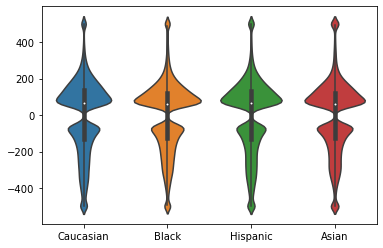

In [18]:
data_names = ['Caucasion','Black','Hispanic','Asian']

sns.violinplot(data = data_array_x)
plt.xticks(np.arange(len(data_array_x)), et_list)
plt.savefig('plots/violinplot_x_dva_ethicities_' + str(threshold) + '.pdf')
plt.show()

### y velocities

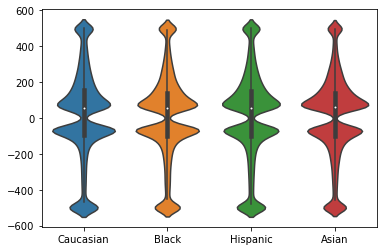

In [19]:
data_names = ['Caucasion','Black','Hispanic','Asian']

sns.violinplot(data = data_array_y)
plt.xticks(np.arange(len(data_array_y)), et_list)
plt.savefig('plots/violinplot_y_dva_ethicities_' + str(threshold) + '.pdf')
plt.show()

###  Plot for velocities for different ethnicities [above 100 dva/s]

In [20]:
num_per_et = 100000
np.random.seed(42)
threshold = 100
et_list = ['Caucasian','Black','Hispanic','Asian']
data_array_x = []
data_array_y = []
for et in et_list:
    et_ids = np.where(normalized_ethnicities_tex == et)[0]
    cur_et_list_x = X_tex[et_ids,:,0].flatten()
    cur_et_list_x = cur_et_list_x[np.abs(cur_et_list_x) >= threshold]
    cur_et_list_y = X_tex[et_ids,:,1].flatten()
    cur_et_list_y = cur_et_list_y[np.abs(cur_et_list_y) >= threshold]
    rand_ids_x = np.random.permutation(np.arange(len(cur_et_list_x)))[0:num_per_et]
    rand_ids_y = np.random.permutation(np.arange(len(cur_et_list_y)))[0:num_per_et]
    cur_et_list_x = cur_et_list_x[rand_ids_x]
    cur_et_list_y = cur_et_list_y[rand_ids_y]
    data_array_x.append(cur_et_list_x)
    data_array_y.append(cur_et_list_y)

### x velocities

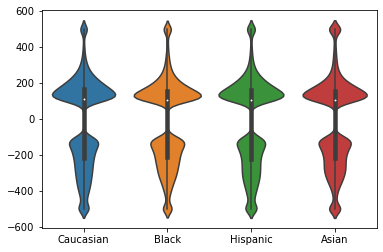

In [21]:
data_names = ['Caucasion','Black','Hispanic','Asian']

sns.violinplot(data = data_array_x)
plt.xticks(np.arange(len(data_array_x)), et_list)
plt.savefig('plots/violinplot_x_dva_ethicities_' + str(threshold) + '.pdf')
plt.show()

### y velocities

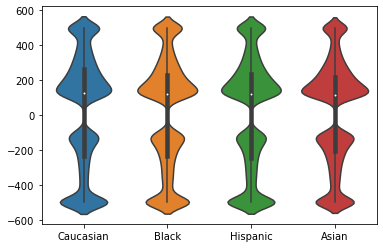

In [22]:
data_names = ['Caucasion','Black','Hispanic','Asian']

sns.violinplot(data = data_array_y)
plt.xticks(np.arange(len(data_array_y)), et_list)
plt.savefig('plots/violinplot_y_dva_ethicities_' + str(threshold) + '.pdf')
plt.show()

###  Plot for velocities for different ethnicities [above 200 dva/s]

In [23]:
num_per_et = 100000
np.random.seed(42)
threshold = 200
et_list = ['Caucasian','Black','Hispanic','Asian']
data_array_x = []
data_array_y = []
for et in et_list:
    et_ids = np.where(normalized_ethnicities_tex == et)[0]
    cur_et_list_x = X_tex[et_ids,:,0].flatten()
    cur_et_list_x = cur_et_list_x[np.abs(cur_et_list_x) >= threshold]
    cur_et_list_y = X_tex[et_ids,:,1].flatten()
    cur_et_list_y = cur_et_list_y[np.abs(cur_et_list_y) >= threshold]
    rand_ids_x = np.random.permutation(np.arange(len(cur_et_list_x)))[0:num_per_et]
    rand_ids_y = np.random.permutation(np.arange(len(cur_et_list_y)))[0:num_per_et]
    cur_et_list_x = cur_et_list_x[rand_ids_x]
    cur_et_list_y = cur_et_list_y[rand_ids_y]
    data_array_x.append(cur_et_list_x)
    data_array_y.append(cur_et_list_y)

### x velocities

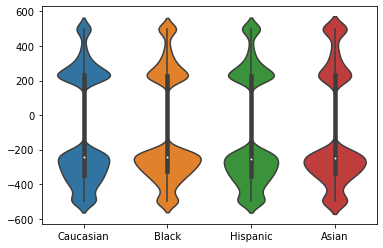

In [24]:
data_names = ['Caucasion','Black','Hispanic','Asian']

sns.violinplot(data = data_array_x)
plt.xticks(np.arange(len(data_array_x)), et_list)
plt.savefig('plots/violinplot_x_dva_ethicities_' + str(threshold) + '.pdf')
plt.show()

### y velocities

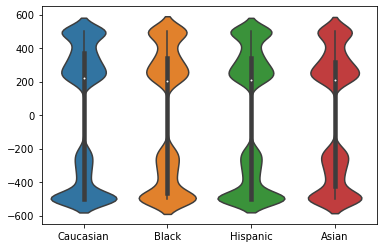

In [25]:
data_names = ['Caucasion','Black','Hispanic','Asian']

sns.violinplot(data = data_array_y)
plt.xticks(np.arange(len(data_array_y)), et_list)
plt.savefig('plots/violinplot_y_dva_ethicities_' + str(threshold) + '.pdf')
plt.show()